In [1]:
import torch
import torchvision
from torch import nn,tensor
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import OrderedDict
from IPython.display import display, clear_output
from tqdm import tqdm_notebook as tqdm

# Data

In [2]:
train_set = torchvision.datasets.MNIST('../data',transform=transforms.Compose([
    transforms.ToTensor()
]))
val_set = torchvision.datasets.MNIST('../data',train=False,transform=transforms.Compose([
    transforms.ToTensor()
]))
val_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

In [3]:
# create Data loader
train_dl = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True,num_workers=12)
val_dl = torch.utils.data.DataLoader(val_set,batch_size=32,shuffle=True,num_workers=12)

tensor([6, 4, 8, 7, 7, 1, 9, 8, 7, 4, 9, 9, 4, 4, 8, 8, 9, 8, 9, 1, 1, 3, 7, 4,
        7, 5, 5, 6, 0, 7, 2, 4])


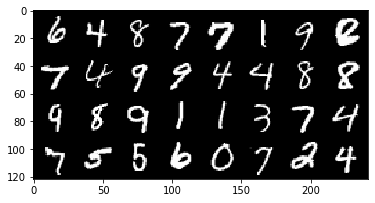

In [4]:
x = next(iter(train_dl))
grid = torchvision.utils.make_grid(x[0])
plt.imshow(np.transpose(grid,(1,2,0)))
print(x[1])

# Architecture/Model

In [5]:
x[0].size(1)

1

In [6]:
class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.size(0),-1)

In [7]:
class ResBlock(nn.Module):
    def __init__(self,size):
        super(ResBlock,self).__init__()
        self.conv1 = nn.Conv2d(size,size,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(size,size,kernel_size=3,stride=1,padding=1)
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        return x + out

In [13]:
model = nn.Sequential(
    nn.Conv2d(x[0].size(1),16,kernel_size=3,stride=2,padding=1), #14
#     ResBlock(16),
    nn.ReLU(),
    nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1), #8
#     ResBlock(32),
    nn.ReLU(),
    nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1), #4
#     ResBlock(64),
    nn.ReLU(),
    nn.Conv2d(64,32,kernel_size=3,stride=2,padding=1), #2
#     ResBlock(32),
    nn.ReLU(),
    nn.Conv2d(32,16,kernel_size=3,stride=2,padding=1), #1
    Flatten(),
    nn.Linear(16,10)
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten()
  (10): Linear(in_features=16, out_features=10, bias=True)
)

# Loss function

In [14]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

# optimizer

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

# start training

In [16]:
def one_epoch_train(train_dl,model):
    results = OrderedDict()
#     model.cuda()
    running_loss = 0
    for img,y in tqdm(train_dl):
#         img,y = img.cuda(),y.cuda()
        optimizer.zero_grad()
        y_hat = model(img)
        loss = loss_func(y_hat,y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
#     print('train accuracy:',(y_hat.argmax(1)==y).float().mean())
    with torch.no_grad():
        correct = 0
        loss = 0
        for img,y in val_dl:
            y_hat = model(img)
            loss += loss_func(y_hat,y)
            correct += (y_hat.argmax(1)==y).float().sum()
#         print('running loss',loss.item())
#         print('valid accuracy',correct.item()/len(val_set))  
    results['loss'] = running_loss / len(train_dl)
    results["valid_loss"] = loss.item() / len(val_dl)
    results['accuracy'] = (y_hat.argmax(1)==y).float().mean().item()
    results["valid_acc"] = correct.item()/len(val_set)
    run_data.append(results)
    df = pd.DataFrame.from_dict(run_data)
    clear_output(wait=True)
    display(df)
    

In [17]:
run_data = []
for i in range(5):
    one_epoch_train(train_dl,model)
#     valid(model,val_dl)

,loss,valid_loss,accuracy,valid_acc
0,0.250827,0.145149,0.9375,0.9594


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sani/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-1b4a4fc20ee7>", line 3, in <module>
    one_epoch_train(train_dl,model)
  File "<ipython-input-16-39ecac23eb7c>", line 5, in one_epoch_train
    for img,y in tqdm(train_dl):
  File "/home/sani/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 223, in __iter__
    for obj in super(tqdm_notebook, self).__iter__(*args, **kwargs):
  File "/home/sani/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1005, in __iter__
    for obj in iterable:
  File "/home/sani/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 576, in __next__
    idx, batch = self._get_batch()
  File "/home/sani/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 

KeyboardInterrupt: 